# Visualizing WhatsApp Chats

### Importing Modules:
* re - for using regex expressions
* pandas - for exploiting dataframes
* matplotlib - for visualization (inline for ploting dataframes)

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Exported chats
Export WhatsApp chats as follows:
* Navigate to contact/group you want to export chat of
* Tap on the menu (3dots in the right corner)
* Tap on more and then tap on Export chat
* Choose WITHOUT MEDIA from the prompt
* Wait for a moment on the Initializing screen
* Share through mail or any other means
* Gather the exported text file

The text file should have a name as: WhatsApp Chat with ... .txt. Use the same below in the filename variable

In [2]:
filename = 'WhatsApp Chat with Group.txt'
file = open(filename, 'r', encoding="utf8")

In [3]:
raw_data = file.read().splitlines()
# print(raw_data)
file.close()

#### Regex
Regex for catching the header expression:

12/14/18, 1:28 PM - Person 1: Hello!

(date), (12-hour-time) - (sender-name): (Message)

In [4]:
header_regex = re.compile(r'(\d+\/\d+\/\d+)(,)(\s)(\d+:\d+)(\s)(\w+)(\s)(-)(\s[^:]+)*(:)(\s)')

Breaking the captured regex, throughout the file and storing it in a dictionary

In [5]:
data_dict = {'id': [], 'date': [], 'time': [], 'sender': [], 'msg': []}

i = 0
for m in raw_data:
    mo = header_regex.search(m[:50]) # shorten the search string for faster search
    if mo != None:
        data_dict['id'].append(i)
        i += 1
        date = mo.group(1)
        time = mo.group(4) + mo.group(5) + mo.group(6) # including Meridiem
        sender = mo.group(9)[1:] # ignoring the initial space
        msg = m[len(mo.group(0)):]
        data_dict['date'].append(date)
        data_dict['time'].append(time)
        data_dict['sender'].append(sender)
        data_dict['msg'].append(msg)
    else: # continued msg for a sender
        if(len(data_dict['msg']) != 0):
            data_dict['msg'][-1] += m
            
# print(data_dict)

Converting the dictionary into the main Pandas DataFrame

In [6]:
df = pd.DataFrame(data=data_dict)
# df.head()

## Sender List

In [7]:
senders = df['sender'].unique().tolist()
print(senders)

['Aakash (UEM) (CR)', 'Shruti Harrison (Shruuu)', 'Rittick (UEM) (Ritu)', 'Amitosh Mondal (DJ Tosh)', 'Souptik Sarkar', 'Kinjal Raykarmakar', 'Sandipan (UEM)', 'Sameeha']


In [8]:
!pip install names

# using pseudo names to hide the indentidy of the senders
import names

pseudo_name_list = set()

while len(pseudo_name_list) < len(senders):
    pseudo_name_list.add(names.get_full_name())
    
pseudo_name_list = list(pseudo_name_list)

for i in range(len(senders)):
    df.replace(to_replace=senders[i], value=pseudo_name_list[i], inplace=True)
    
senders = pseudo_name_list

## Sender Message Count

In [9]:
sender_msg_count = df['sender'].value_counts()
print(sender_msg_count)

Regina Taylor       4323
Kimberly Kendall    4314
Maxine Watson       3380
Jacob Ibarra        1956
Mike Lally          1248
Sallie Zavala        765
Lee Walker           458
Masako Colwell        45
Name: sender, dtype: int64


## Bar Chart showing messages sent by each sender

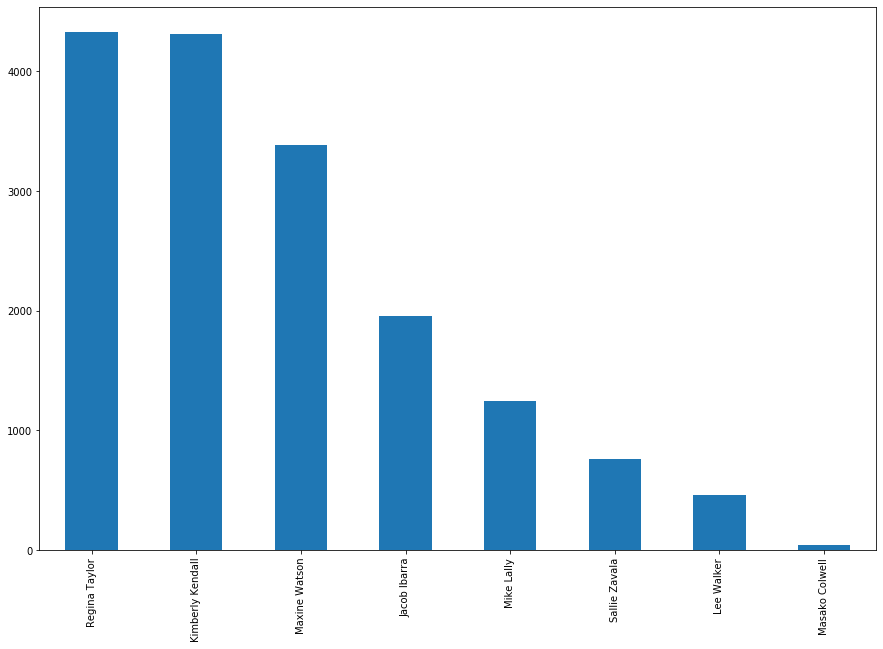

In [10]:
sender_msg_count.plot(kind = 'bar', figsize = (15, 10))
plt.show()

## Pie Chart showing messages sent by each sender

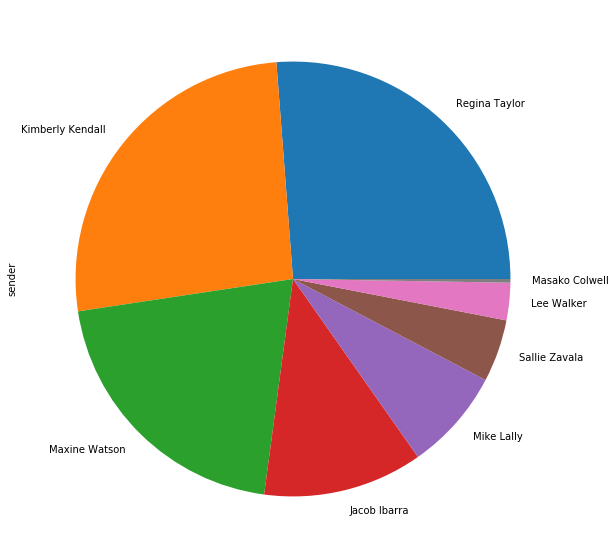

In [11]:
sender_msg_count.plot(kind = 'pie', figsize = (10, 10))
plt.show()

## Bar Chart showing media sent by each sender

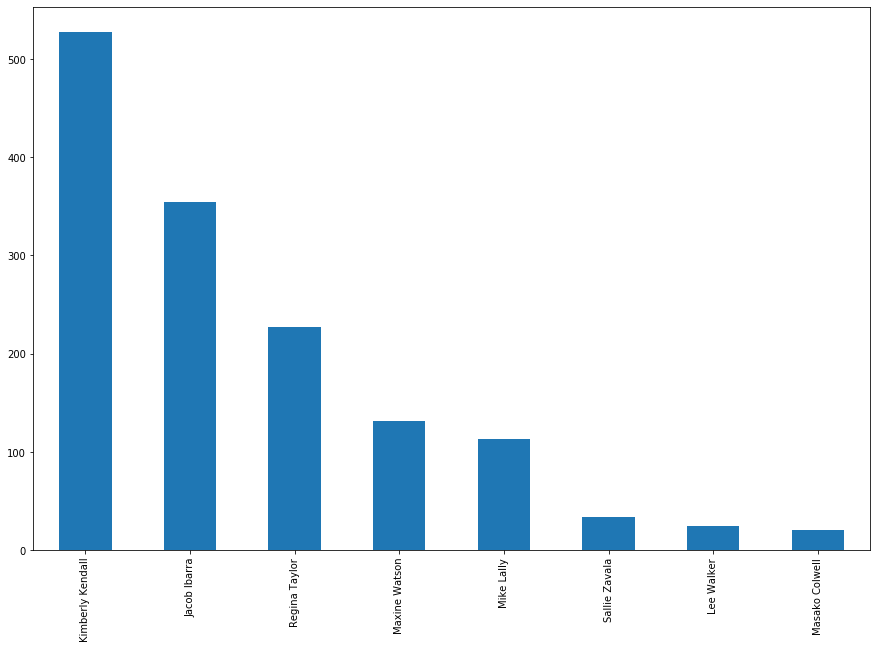

In [12]:
media_msg = df[df['msg'] == '<Media omitted>']
media_msg_count = media_msg['sender'].value_counts()
media_msg_count.plot(kind = 'bar', figsize = (15, 10))
plt.show()

## Pie Chart showing media sent by each sender

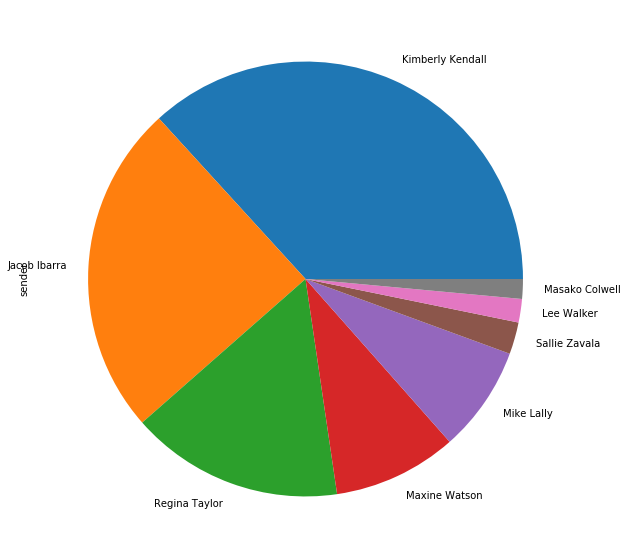

In [13]:
media_msg_count.plot(kind = 'pie', figsize = (10, 10))
plt.show()

## Area Chart showing the total number of messages sent by dates
Days with zero messages are ommited

Calculating the total number of messages datewise, storing it in another Pandas DataFrame

In [14]:
dates = df['date'].unique().tolist() # data list
# print(dates)

temp_dict = {'date': dates, 'msg': []} # no. of msg by date
for d in dates:
    c = 0
    for f in df['date']:
        if d == f:
            c += 1
    temp_dict['msg'].append(c)
    
# print(temp_dict)

datewise_msg_count = pd.DataFrame(data=temp_dict)
# datewise_msg_count.head()

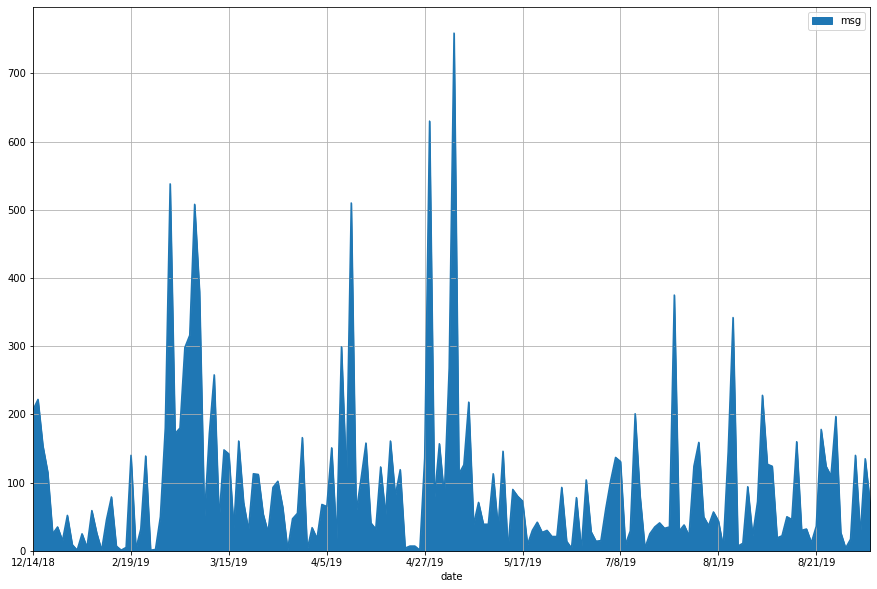

In [15]:
datewise_msg_count.plot(x = 'date', kind = 'area', figsize = (15, 10), grid = True)
plt.show()

## Date on which maximum number of messages were sent

In [16]:
datewise_msg_count.loc[datewise_msg_count['msg'].idxmax()]

date    5/3/19
msg        759
Name: 86, dtype: object

## Date on which minimum number of messages were sent
Days with zero messages are ommited

In [17]:
datewise_msg_count.loc[datewise_msg_count['msg'].idxmin()]

date    1/16/19
msg           1
Name: 9, dtype: object

## Line Chart showing messaging frequency of each sender, datewise, overlapped

Calculating total number of messages sent by each sender on all the dates (senders with zero message in a day are included too)

In [18]:
temp_dict_2 = {'date': dates}
for s in senders:
    temp_dict_2[s] = [] # creating lists for each sender

for s in senders:
    for d in dates:
        date_filter = df['date'] == d # date mask
        sender_filter = df['sender'] == s # sender mask
        c = df['msg'][date_filter & sender_filter].count() # counting occurences of the masked data
        temp_dict_2[s].append(c)
        
# print(temp_dict_2)
senderwise_datewise_msg_count = pd.DataFrame(data=temp_dict_2)
# senderwise_datewise_msg_count.head()

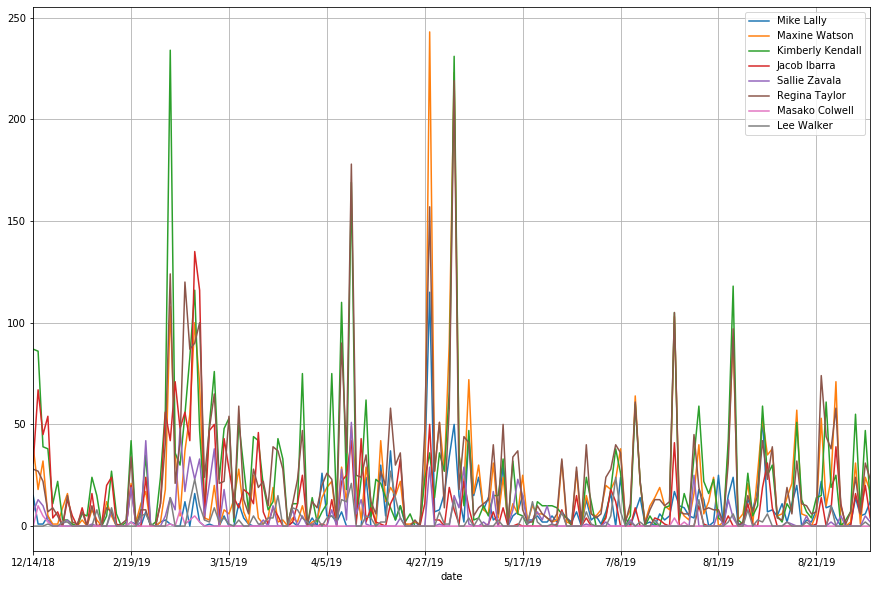

In [19]:
senderwise_datewise_msg_count.plot(x='date', kind = 'line', figsize = (15, 10), grid = True)
plt.show()

## Line Chart showing messaging frequency of each sender, datewise, subplots

In [20]:
# finding maximum message in a day over all senders to set a uniform limit in y axis
max_list = []
for s in senders:
    max_list.append(senderwise_datewise_msg_count[s].max())
    
ymax = max(max_list)


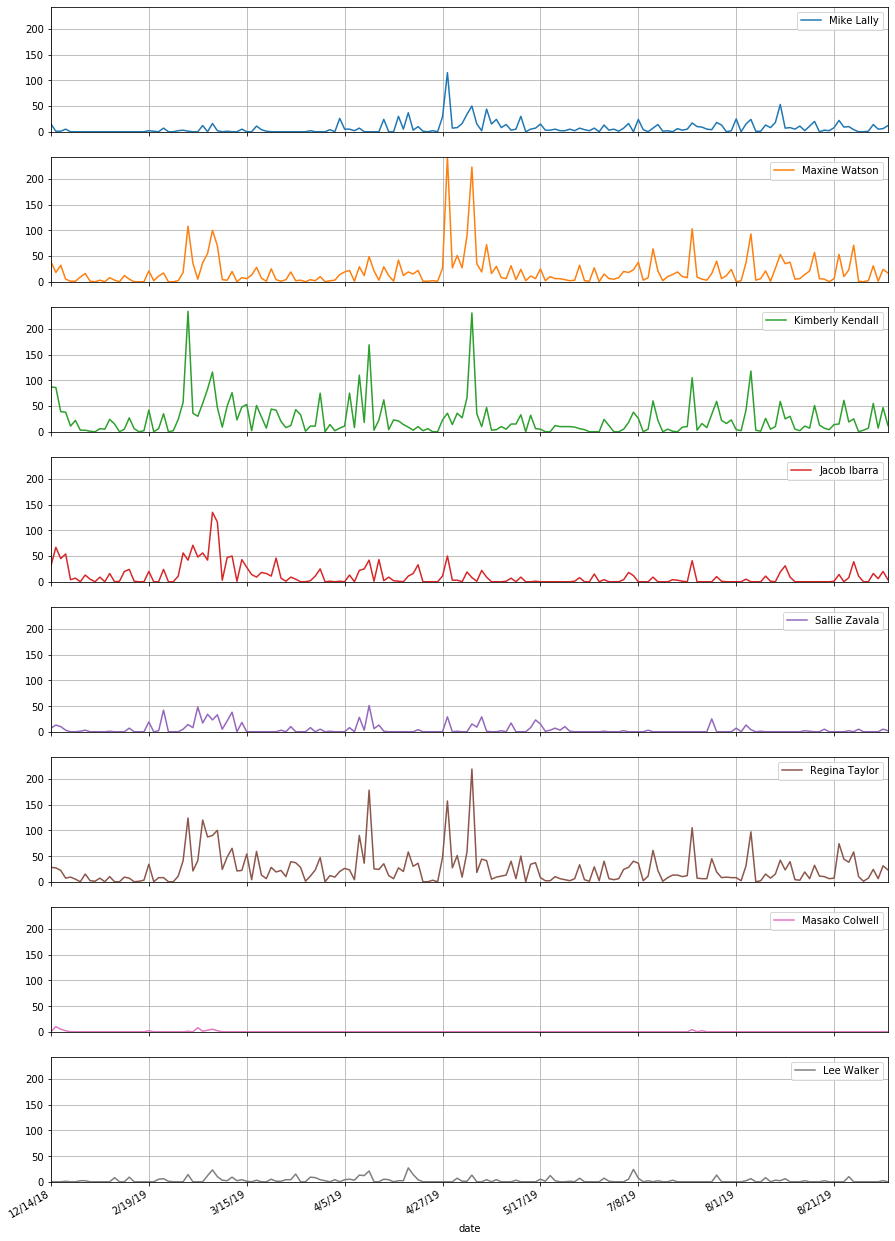

In [21]:
senderwise_datewise_msg_count.plot(x='date', ylim=(0,ymax), kind = 'line', figsize = (15, (3*len(senders))), grid = True, subplots=True)
plt.show()

## Calender Plot showing messaging frequency, datewise

Colours have been normalized between zero and maximum messages in a day (In case of data for multiple years, leading to multiple calender plots for each year)

Year: 18


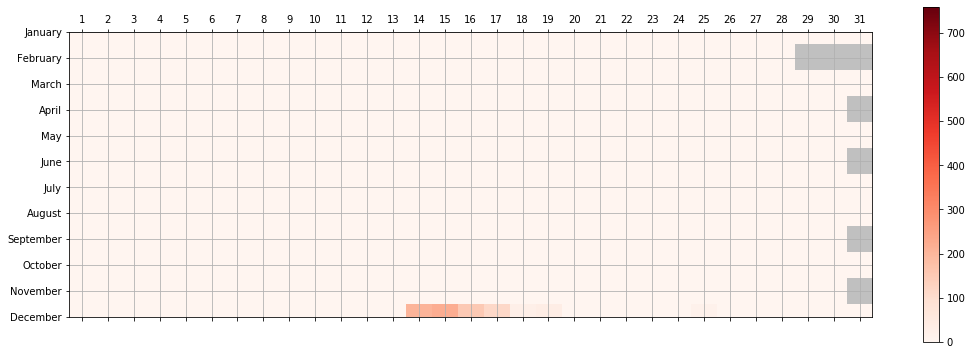

Year: 19


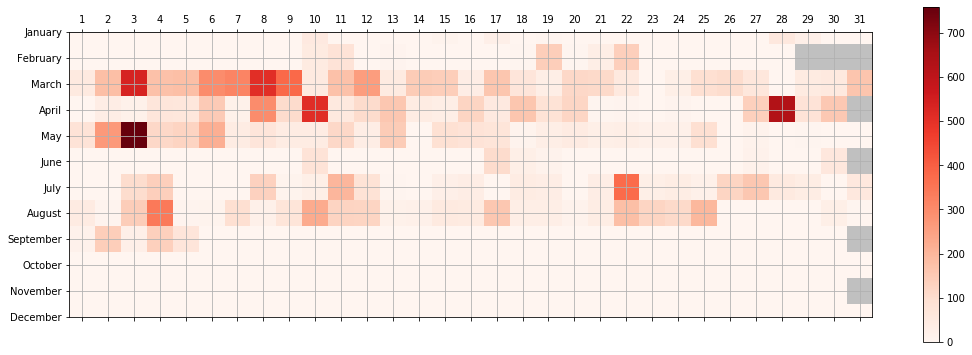

In [22]:
df['date']
date_df = df['date'].str.split('/', n=2, expand = True)
# print(date_df)
max_msg = max(df['date'].value_counts())

calender_mat = np.zeros(shape=(12,31), dtype=float)
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
calender_mat[1][30] = np.nan

for y in date_df[2].unique():
    print("Year:", y)
    year_mask = date_df[2] == y
    for m in date_df[0].unique(): 
        month_mask = date_df[0] == m
        for d in date_df[1].unique():
            day_mask = date_df[1] == d
            calender_mat[int(m)-1][int(d)-1] = date_df[0][year_mask & month_mask & day_mask].count()
    
    year = int(y) + 2000
    if year%4==0 and year%100!=0 or year%400==0:
        month_day[1] = 29
    else:
        month_days[1] = 28

    for i in range(12):
        for j in range(month_days[i], 31):
            calender_mat[i][j] = np.nan
#     print(calender_mat)

    current_cmap = plt.cm.Reds
    current_cmap.set_bad(color='silver')
    
    f = plt.figure(figsize=(18, 6))
#     color_axis = plt.matshow(calender_mat, fignum=f.number, cmap="Reds", vmax=max_msg)
    color_axis = plt.matshow(calender_mat, fignum=f.number, cmap=current_cmap, vmax=max_msg)

    plt.colorbar(color_axis)
    plt.xticks(range(31), range(1, 32))
    plt.yticks(range(12), month_list)    
    
    plt.grid()
    plt.show()

## Datewise Corelation between senders

In [23]:
corr_df = senderwise_datewise_msg_count.corr().abs()
corr_df.style.background_gradient(cmap='Reds').set_precision(3)

,Mike Lally,Maxine Watson,Kimberly Kendall,Jacob Ibarra,Sallie Zavala,Regina Taylor,Masako Colwell,Lee Walker
Mike Lally,1,0.73,0.258,0.0844,0.0795,0.483,0.0441,0.0992
Maxine Watson,0.73,1,0.656,0.389,0.309,0.814,0.143,0.286
Kimberly Kendall,0.258,0.656,1,0.485,0.45,0.806,0.275,0.453
Jacob Ibarra,0.0844,0.389,0.485,1,0.557,0.507,0.541,0.319
Sallie Zavala,0.0795,0.309,0.45,0.557,1,0.544,0.375,0.302
Regina Taylor,0.483,0.814,0.806,0.507,0.544,1,0.187,0.464
Masako Colwell,0.0441,0.143,0.275,0.541,0.375,0.187,1,0.068
Lee Walker,0.0992,0.286,0.453,0.319,0.302,0.464,0.068,1


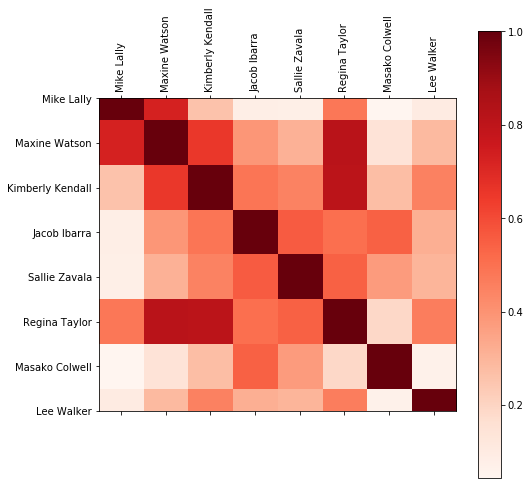

In [24]:
f = plt.figure(figsize=(len(senders), len(senders)))
color_axis = plt.matshow(corr_df, fignum=f.number, cmap="Reds")
plt.colorbar(color_axis)
plt.xticks(range(corr_df.shape[1]), corr_df.columns, rotation=90)
plt.yticks(range(corr_df.shape[1]), corr_df.columns)

plt.show()

In [25]:
# seperating redundant pairs
imposs_pairs = set()
for i in senders:
    for j in senders:
        if (i, j) not in imposs_pairs and (j, i) not in imposs_pairs:
            imposs_pairs.add((i, j))

corr_pair = corr_df.unstack().drop(labels = imposs_pairs).sort_values(ascending=False)
corr_pair

Regina Taylor     Maxine Watson       0.814219
                  Kimberly Kendall    0.805883
Maxine Watson     Mike Lally          0.730226
Kimberly Kendall  Maxine Watson       0.655820
Sallie Zavala     Jacob Ibarra        0.556858
Regina Taylor     Sallie Zavala       0.543985
Masako Colwell    Jacob Ibarra        0.541066
Regina Taylor     Jacob Ibarra        0.506633
Jacob Ibarra      Kimberly Kendall    0.485095
Regina Taylor     Mike Lally          0.482539
Lee Walker        Regina Taylor       0.463686
                  Kimberly Kendall    0.452509
Sallie Zavala     Kimberly Kendall    0.450120
Jacob Ibarra      Maxine Watson       0.388828
Masako Colwell    Sallie Zavala       0.374995
Lee Walker        Jacob Ibarra        0.319418
Sallie Zavala     Maxine Watson       0.309397
Lee Walker        Sallie Zavala       0.301568
                  Maxine Watson       0.285562
Masako Colwell    Kimberly Kendall    0.275119
Kimberly Kendall  Mike Lally          0.257620
Masako Colwel

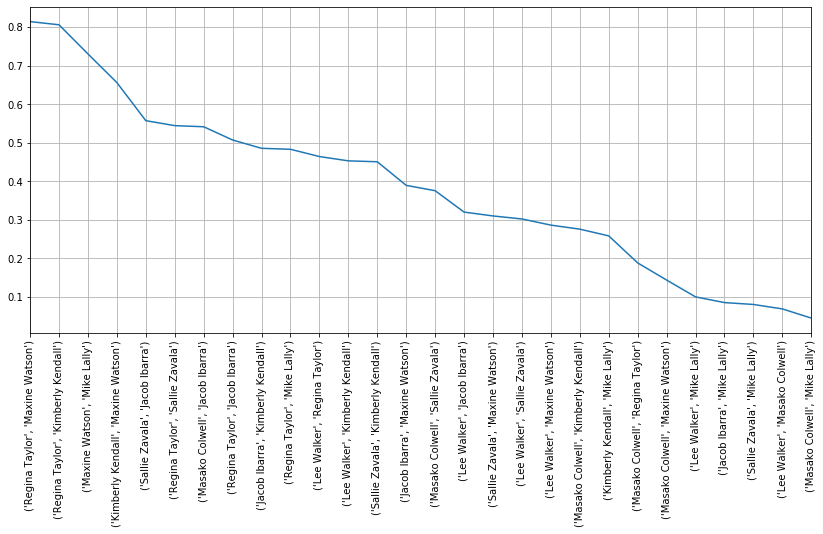

In [26]:
pair_list = list(corr_pair.index)
plt.figure(figsize=(len(pair_list)/2, 6))
corr_pair.plot(grid=True)
plt.xticks(range(len(pair_list)), pair_list, rotation=90)
plt.show()

## Bar Chart showing hourly messaging frequency

Grouping time by 1 hour intervals throughout the day, over all dates

In [27]:
times = [] # hour list(filters only hour from each time)
time_regex = re.compile(r'(\d+):(\d+)(\s)(\w+)')
for t in df['time']:
    mo = time_regex.search(t)
    if mo.group(4) == 'PM' and mo.group(1) == '12':
        times.append(12)
    elif mo.group(4) == 'PM':
        times.append(int(mo.group(1)) + 12)
    elif mo.group(4) == 'AM' and mo.group(1) == '12':
        times.append(0)
    else:
        times.append(int(mo.group(1)))
        
time_dict = {'time': times, 'msg': list(df['msg'])}
time_df = pd.DataFrame(data=time_dict) # contains hour and msg
# print(time_df)

time_count_dict = {'hour': [], 'msg': []} # hour and count of msgs
for i in range(0, 24):
    match = (str(i) + ':')
    time_filter = time_df['time'] == i # hour mask
    time_count_dict['hour'].append(i)
    time_count_dict['msg'].append(time_df['msg'][time_filter].count())

# print(time_count_dict)

time_count_df = pd.DataFrame(data=time_count_dict)
# time_count_df

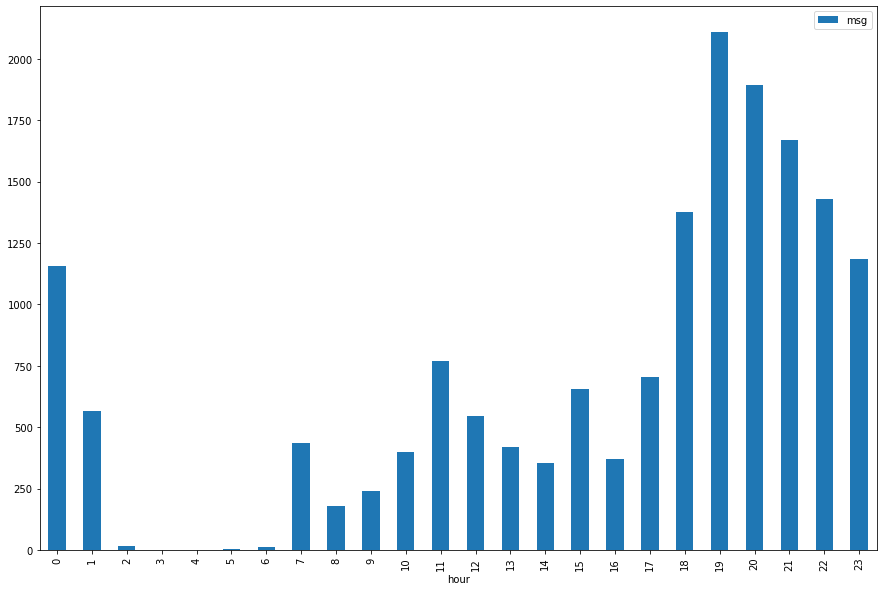

In [28]:
time_count_df.plot(x = 'hour', kind = 'bar', figsize = (15, 10))
plt.show()

## Bar Chart showing hourly messaging frequency, senderwise

In [29]:
time_sender_dict = {'time': times, 'sender':list(df['sender']), 'msg': list(df['msg'])}

time_sender_df = pd.DataFrame(data=time_sender_dict)
time_sender_df

time_count_senderwise_dict = {'hour': list(range(24))}
time_count_senderwise_df = pd.DataFrame(data=time_count_senderwise_dict)

for i in range(0, 24):
    match = (str(i) + ':')
    time_filter = time_sender_df['time'] == i # hour mask
    
    for s in senders:
        sender_filter = time_sender_df['sender'] == s
        if s not in time_count_senderwise_df.columns:
            time_count_senderwise_df[s] = list(range(24))
        count = time_sender_df['msg'][time_filter & sender_filter].count()
        time_count_senderwise_df.at[i, s] = count

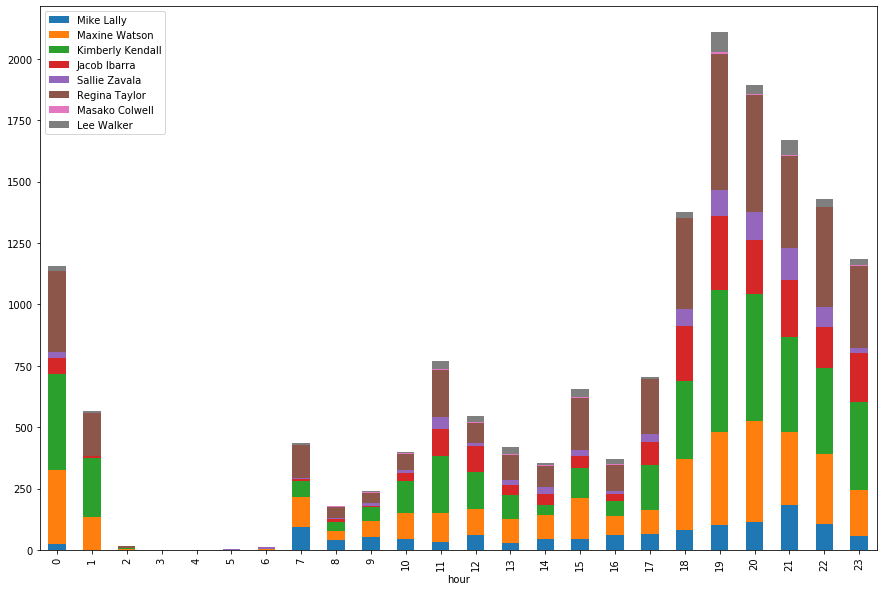

In [30]:
time_count_senderwise_df.plot(x = 'hour', kind = 'bar', stacked=True, figsize = (15, 10))
plt.show()

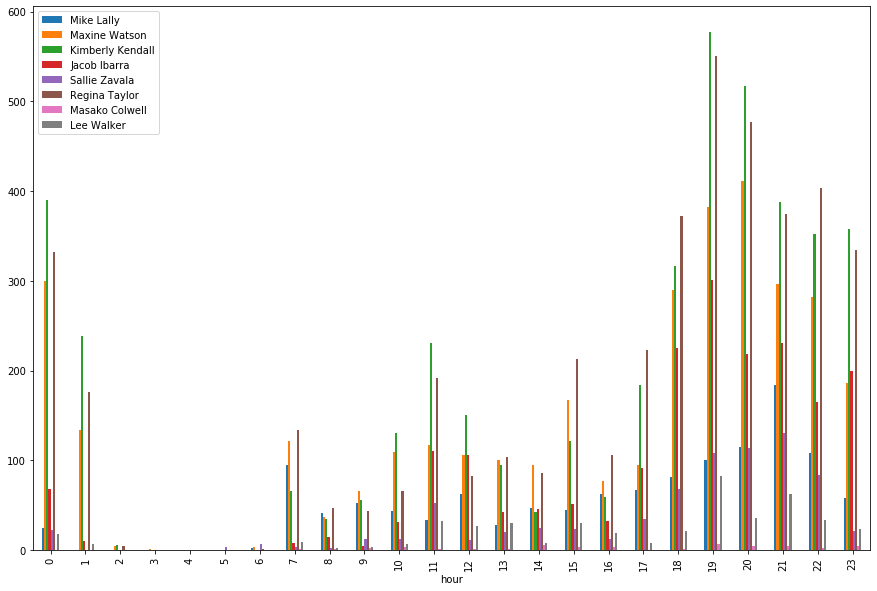

In [31]:
time_count_senderwise_df.plot(x = 'hour', kind = 'bar', figsize = (15, 10))
plt.show()